In [1]:
from scipy.io import loadmat
from pathlib import Path

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [2]:
def get_data_path(name, data_home="../datasets/tmp", as_str=True):

    path = Path(data_home).joinpath(f"{name}_KRR_results_CV.mat")

    if as_str:
        return str(path)

    return path

In [3]:
def make_data(mat, key):

    data = pd.DataFrame(data=mat.get(key), 
                        columns=mat.get("kw_factors").squeeze(axis=0))

    data.index.name = "split"
    data.columns.name = "kw_factor"

    s = data.stack()
    s.name = "error"

    return s.reset_index()

In [4]:
def generate_key(base="NMSE", method="KLIEP", cv=False, projection=None):

    s = []
    s.append(base)
    s.append(method)

    if cv:
        s.append("CV")

    if projection != "none":
        s.append(projection)

    return '_'.join(s)

In [5]:
generate_key(projection="low")

'NMSE_KLIEP_low'

In [6]:
methods = ["KLIEP", "RuLSIF", "cov"]
projections = ["none", "PCA", "low"]

In [7]:
dataset_name = "ailerons"
mat = loadmat(get_data_path(dataset_name))

In [8]:
dataset_names = ["abalone", "ailerons", "bank32", "bank8", "cali", "cpuact",
                 "elevators", "puma8"]

In [9]:
frames = []

for dataset_name in dataset_names:

    mat = loadmat(get_data_path(dataset_name))

    for method in methods:
        for projection in projections:
            key = generate_key(method=method, 
                               projection=projection)
            df = make_data(mat, key=key).assign(dataset_name=dataset_name, 
                                                method=method, 
                                                projection=projection)
            frames.append(df)

In [10]:
data1 = pd.concat(frames, axis="index", sort=True)
data1

,dataset_name,error,kw_factor,method,projection,split
0,abalone,1.035861,0.10,KLIEP,none,0
1,abalone,0.984125,0.25,KLIEP,none,0
2,abalone,0.930860,0.50,KLIEP,none,0
3,abalone,0.937177,1.00,KLIEP,none,0
4,abalone,1.026680,2.00,KLIEP,none,0
...,...,...,...,...,...,...
75,puma8,0.323778,1.00,cov,low,9
76,puma8,0.345948,2.00,cov,low,9
77,puma8,0.339254,3.00,cov,low,9
78,puma8,0.334732,5.00,cov,low,9


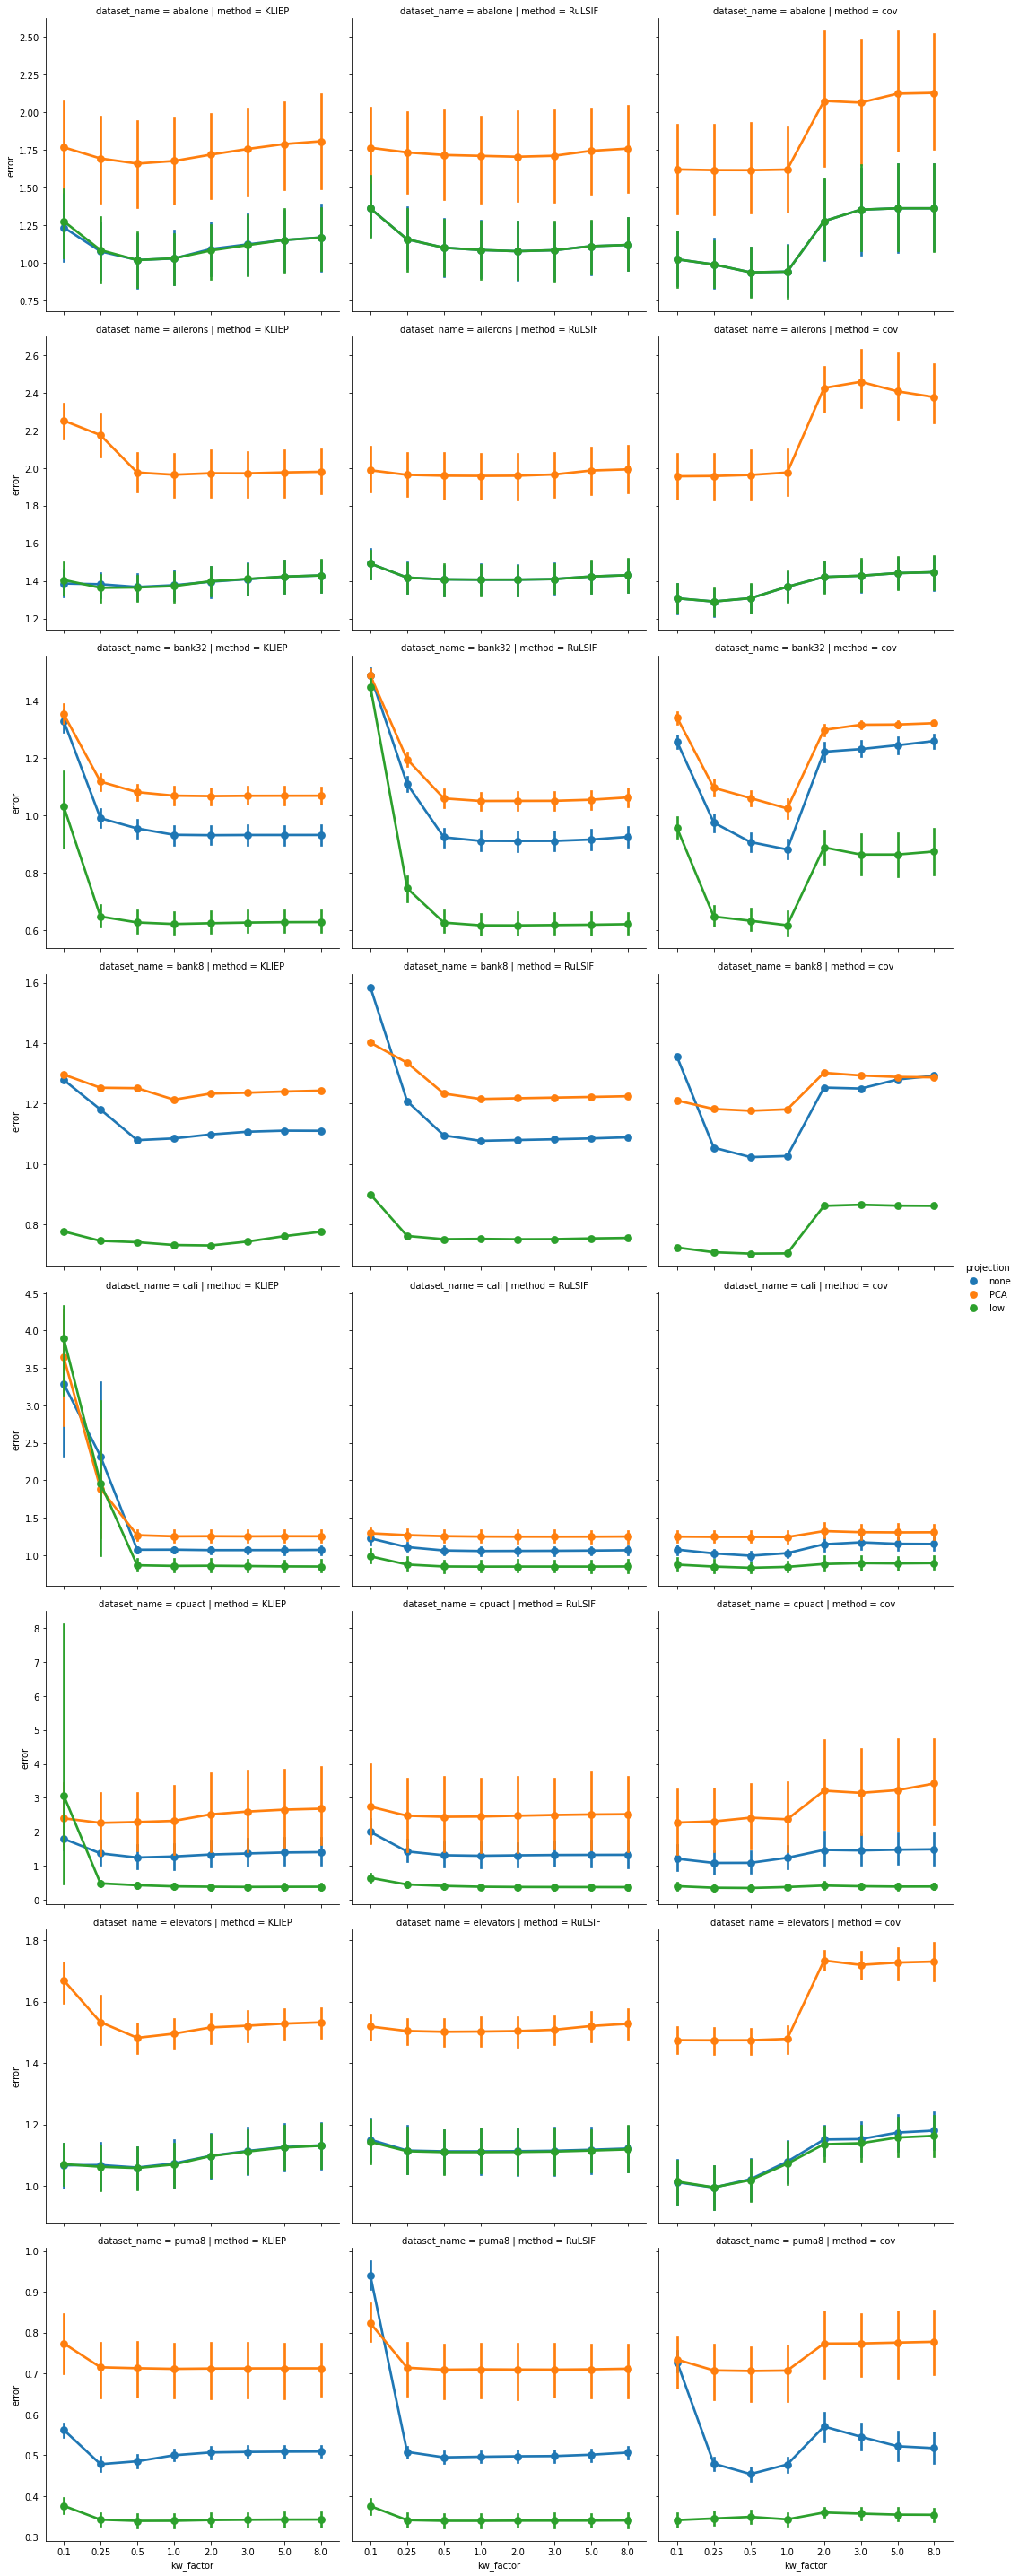

In [11]:
g = sns.catplot(x="kw_factor", y="error", hue="projection",
                row="dataset_name", col="method", 
                kind="point", data=data1, sharey="row")

In [12]:
methods = ["KLIEP", "RuLSIF", "LHSS"]
projections = ["none", "PCA", "low"]

In [13]:
rows = []
for dataset_name in dataset_names:

    mat = loadmat(get_data_path(dataset_name))

    for method in methods:
        
        cv = False if method == "LHSS" else True
        squeeze_axis = 0 if method == "RuLSIF" else -1
            
        for projection in projections:

            key = generate_key(method=method, cv=cv,
                               projection=projection)

            for split, error in enumerate(mat[key].squeeze(axis=squeeze_axis)):
                row = dict(dataset_name=dataset_name, split=split, kw_factor="cv",
                           method=method, projection=projection, error=error)
                rows.append(row)

In [14]:
data2 = pd.DataFrame(rows)
data2

,dataset_name,split,kw_factor,method,projection,error
0,abalone,0,cv,KLIEP,none,0.917131
1,abalone,1,cv,KLIEP,none,1.228142
2,abalone,2,cv,KLIEP,none,0.628196
3,abalone,3,cv,KLIEP,none,1.537935
4,abalone,4,cv,KLIEP,none,1.410188
...,...,...,...,...,...,...
688,puma8,5,cv,LHSS,low,NaN
689,puma8,6,cv,LHSS,low,NaN
690,puma8,7,cv,LHSS,low,NaN
691,puma8,8,cv,LHSS,low,NaN


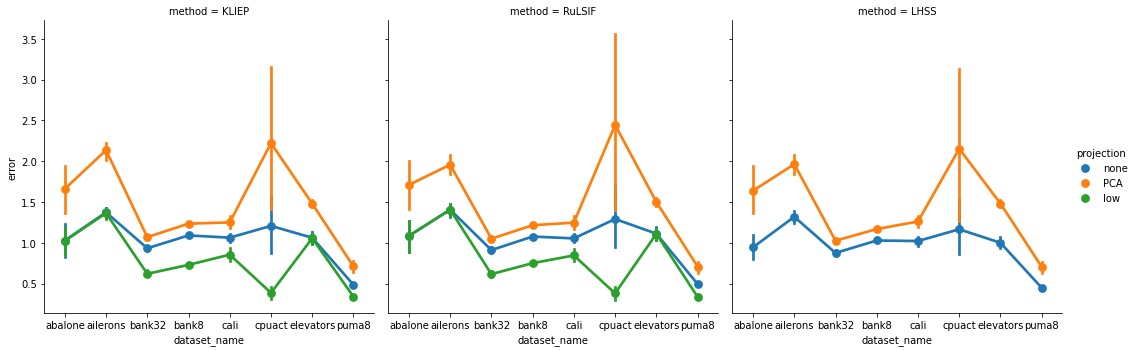

In [15]:
g = sns.catplot(x="dataset_name", y="error", hue="projection",
                col="method", kind="point", data=data2,
                sharey="row")

In [16]:
data = pd.concat([data1, data2], axis="index", sort=True)
data

,dataset_name,error,kw_factor,method,projection,split
0,abalone,1.035861,0.1,KLIEP,none,0
1,abalone,0.984125,0.25,KLIEP,none,0
2,abalone,0.930860,0.5,KLIEP,none,0
3,abalone,0.937177,1,KLIEP,none,0
4,abalone,1.026680,2,KLIEP,none,0
...,...,...,...,...,...,...
688,puma8,NaN,cv,LHSS,low,5
689,puma8,NaN,cv,LHSS,low,6
690,puma8,NaN,cv,LHSS,low,7
691,puma8,NaN,cv,LHSS,low,8


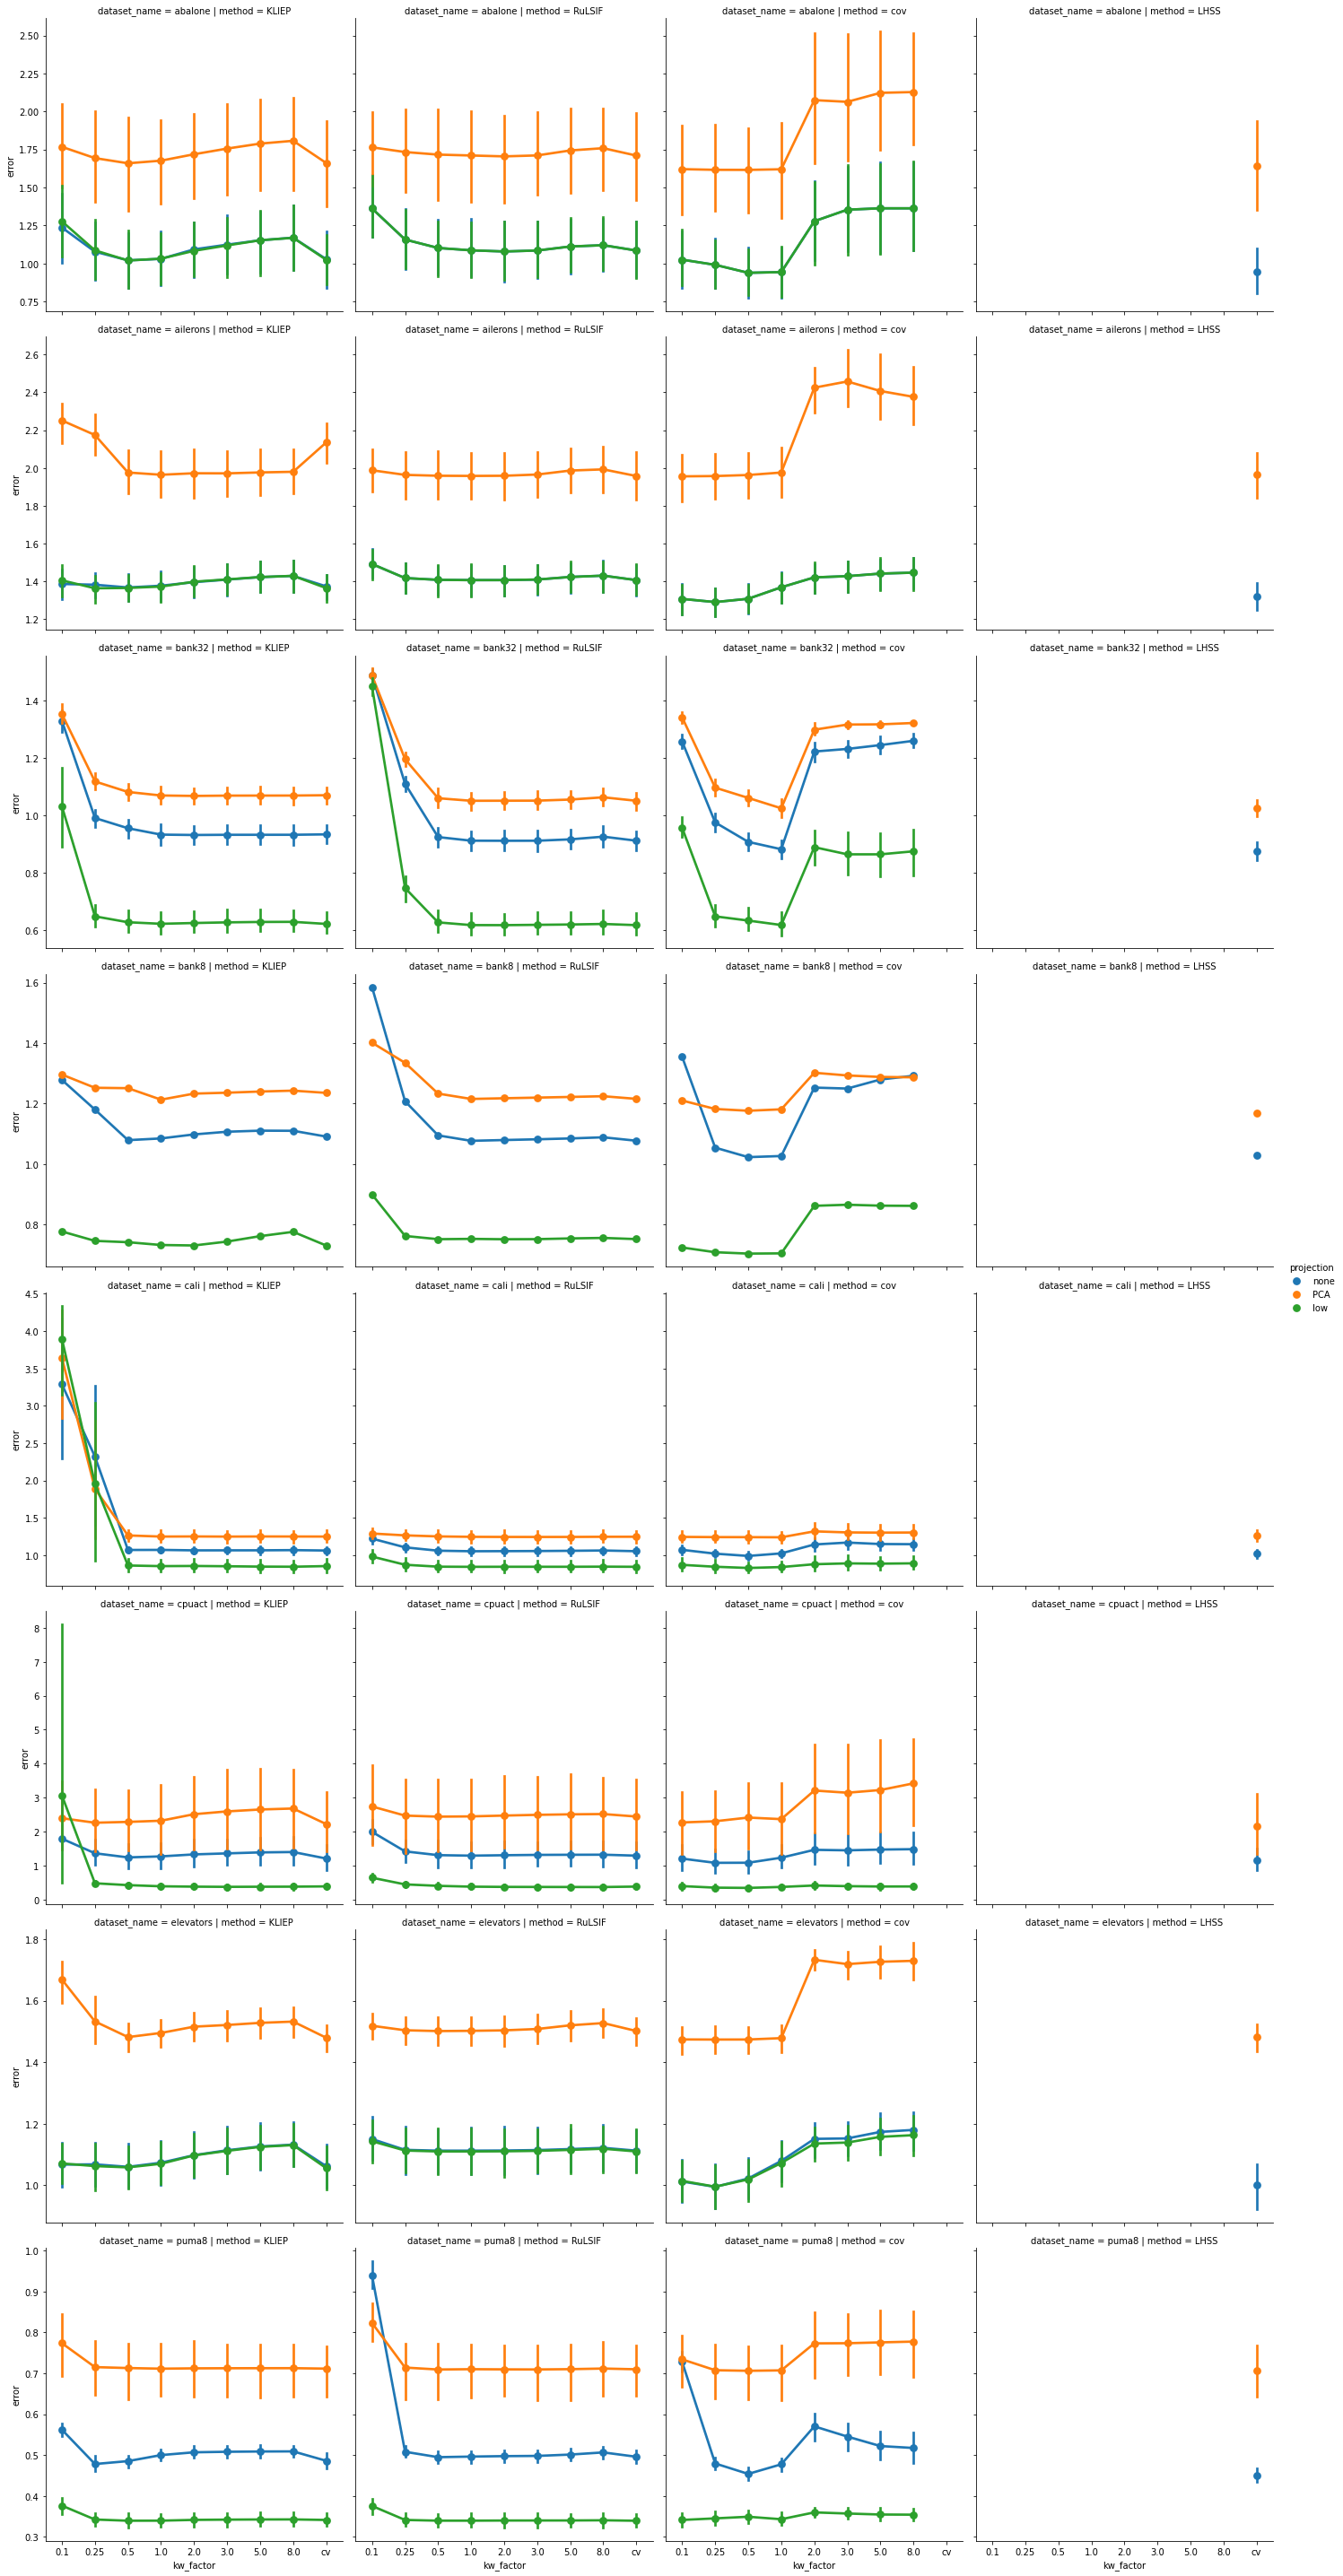

In [17]:
g = sns.catplot(x="kw_factor", y="error", hue="projection",
                row="dataset_name", col="method", 
                kind="point", data=data, sharey="row")
g.savefig("grid.png")
g.savefig("grid.pdf")